In [2]:
pip install quandl

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import quandl
# Get attendees to get their own key.
quandl.ApiConfig.api_key = 'gYyp7CLTPWqhbsyFNAN2' 

# Select a basket of stocks to work with. They can pick their own.
selected = ['CNP', 'F', 'WMT',  'GE', 'TSLA']

# Get the data from Quandl for these stock
data = quandl.get_table('WIKI/PRICES', ticker=selected,
                        qopts={ 'columns': ['ticker', 'date', 'adj_close']},
                        date ={ 'gte': '2014-1-1', 'lte': '2016-12-31'}, 
                        paginate=True)

# Check the data, what's it look like?
data.head()

,ticker,date,adj_close
None,,,
0,WMT,2016-12-30,67.742045
1,WMT,2016-12-29,67.879254
2,WMT,2016-12-28,67.928257
3,WMT,2016-12-27,68.310482
4,WMT,2016-12-23,68.153672


In [4]:
# Wrangle the data - set the index to date, and pivot the table
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

# What's our data look like now?
table.head()

adj_close                                         
ticker            CNP          F         GE    TSLA        WMT
date                                                          
2014-01-02  19.116238  12.726742  24.266002  150.10  71.343743
2014-01-03  19.107861  12.784441  24.248354  149.56  71.108673
2014-01-06  19.132992  12.842140  24.054226  147.00  70.710863
2014-01-07  19.334039  12.677286  24.080698  149.36  70.927850
2014-01-08  19.132992  12.809169  24.010106  151.28  70.367299

In [5]:
# Calculate the daily annual returns for the stocks.
# 250 is a good approximation of a trading year

returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250 
returns_annual

           ticker
adj_close  CNP       0.091859
           F        -0.007358
           GE        0.095399
           TSLA      0.204873
           WMT      -0.000943
dtype: float64

In [6]:
# Get the daily covariance of returns of the stock.
# This is effectively, how much does one stock deviate from the mean.
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# Read this table as....
# If all your stock if F (facebook), you'd get 6% volatility 
# (variance from the mean) over the year.
# If you had 50% F (facebook) and 50% (GE), you'd get 2% volatility 
# (variance from the mean) over the year.
cov_annual

adj_close                                        
ticker                 CNP         F        GE      TSLA       WMT
          ticker                                                  
adj_close CNP     0.040941  0.014076  0.015147  0.017508  0.010534
          F       0.014076  0.052813  0.021476  0.029219  0.011608
          GE      0.015147  0.021476  0.033564  0.022247  0.010747
          TSLA    0.017508  0.029219  0.022247  0.176760  0.012628
          WMT     0.010534  0.011608  0.010747  0.012628  0.032357

In [7]:
# Now calculate the efficient frontier - over 50,000 permutations of the stocks

port_returns = []
port_volatility = []
stock_weights = []

num_assets = len(selected)
num_portfolios = 50000

# Set a random seed, for reprodicibility
np.random.seed(101)

for p in range(num_portfolios):
    
    # Calculate a random weight, and make it a percentage of 
    # all the weights calculated for this basket.
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    # Calculate the returns for this weighting of stocks, 
    # using the annual returns
    returns = np.dot(weights, returns_annual)
    
    # Calculate the volatility for this weighting of stocks, 
    # using the annual coveriance values
    # Effictively std. deviation
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    
    # Store the values for this portfolio
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    
# Add a dictionary for Returns and Risk values of each portfolio
portfolio = { 'Returns': port_returns, 'Volatility': port_volatility }

# Extend the dictionary, to accomdate each ticker and weight in the portfolio
for counter, symbol in enumerate(selected):
    portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]
                                     
# Finally! Make a DataFrame...
df = pd.DataFrame(portfolio)
                                     
# What's our data look like?
df.head()


,Returns,Volatility,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
0,0.040788,0.149496,0.261820,0.289335,0.014437,0.086964,0.347444
1,0.104291,0.176221,0.283065,0.104199,0.303335,0.244927,0.064474
2,0.079494,0.176328,0.195196,0.124019,0.064062,0.276685,0.340038
3,0.118147,0.206389,0.120722,0.043415,0.313581,0.378758,0.143523
4,0.058253,0.159980,0.434703,0.328493,0.030755,0.087453,0.118597


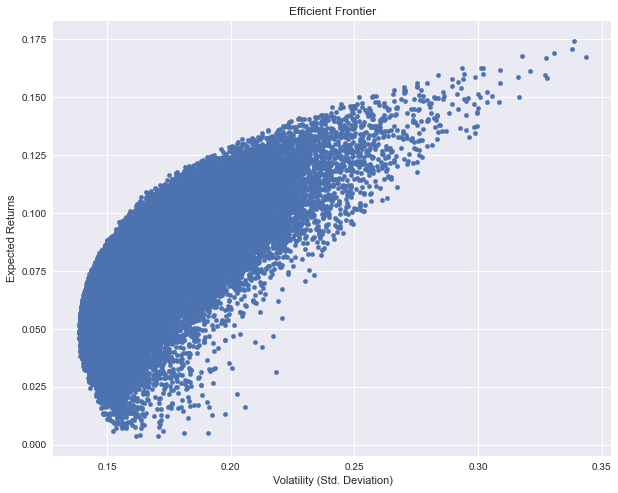

In [9]:
 #Visualize the frontier!
# Use a scatter plot, and use seaborn colour styling...
plt.style.use('seaborn')
df.plot.scatter(x='Volatility',y='Returns',figsize=(10,8),grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [10]:
# Now introduce the sharpe ratio.
#
#   ratio = Rp - Rfp
#           --------
#              ap
#
# Rp = Expected Reward (we have this)
# Rfp = Risk-Free Reward (we have a value of 0 for this)
# ap = Risk (Volatility) - we have this.

In [11]:
port_returns = []
port_volatility = []
stock_weights = []

# THIS IS NEW
sharpe_ratio = []

num_assets = len(selected)
num_portfolios = 50000

# Set a random seed, for reprodicibility
np.random.seed(101)

for p in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    
    # THIS IS NEW
    ratio = returns/volatility
    
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    
    # THIS IS NEW
    sharpe_ratio.append(ratio)
    
# THIS HAS AN EXTRA VALUE
portfolio = { 'Returns': port_returns, 
              'Volatility': port_volatility, 
              'Sharpe Ratio': sharpe_ratio }

for counter, symbol in enumerate(selected):
    portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

df = pd.DataFrame(portfolio)

df.head()


,Returns,Volatility,Sharpe Ratio,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
0,0.040788,0.149496,0.272835,0.261820,0.289335,0.014437,0.086964,0.347444
1,0.104291,0.176221,0.591821,0.283065,0.104199,0.303335,0.244927,0.064474
2,0.079494,0.176328,0.450830,0.195196,0.124019,0.064062,0.276685,0.340038
3,0.118147,0.206389,0.572448,0.120722,0.043415,0.313581,0.378758,0.143523
4,0.058253,0.159980,0.364128,0.434703,0.328493,0.030755,0.087453,0.118597


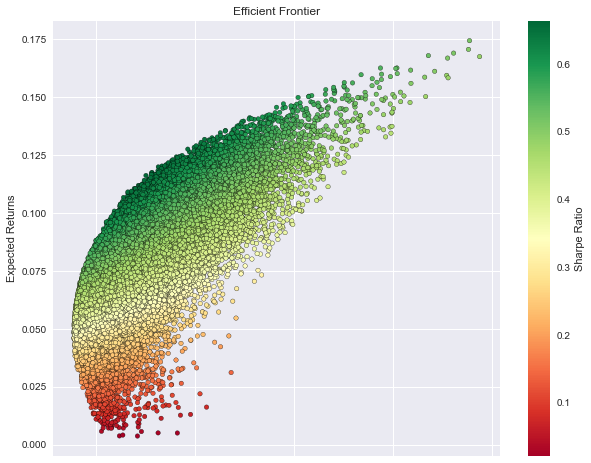

In [12]:
# Plot the efficient frontier, but this time, use a heatmap to colour code
# based on the sharpe ratio...

plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns',  c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10,8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

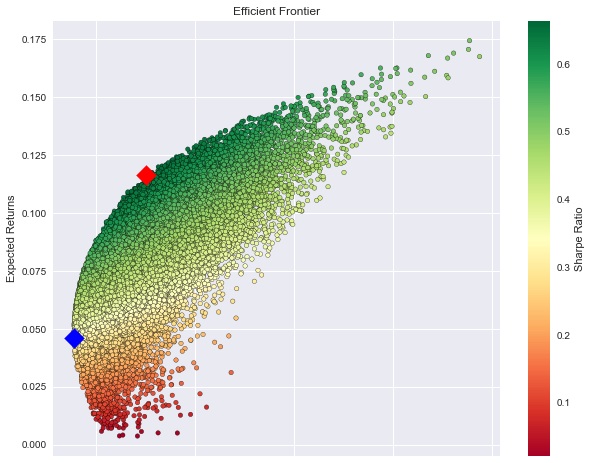

In [13]:
# Now, figure out what the max profit is we could get...
max_sharpe = df['Sharpe Ratio'].max()
sharpe_portfolio  = df.loc[df['Sharpe Ratio'] == max_sharpe]

# And figure out the most risk-averse portfolio...
min_volatility = df['Volatility'].min()
min_volatility_portfolio = df.loc[df['Volatility'] ==  min_volatility]

# Plot these as extra points on the graph...

plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns',  c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10,8), grid=True)

# These are new compared to the previous plot...
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], 
            c='red', marker='D', s=200)

plt.scatter(x=min_volatility_portfolio['Volatility'], 
            y=min_volatility_portfolio['Returns'], 
            c='blue', marker='D', s=200)

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [14]:
# Finally, to get the specifics of the two portfolios, 
# print them out...

print(min_volatility_portfolio.T*100)
print(sharpe_portfolio.T*100)

                  17879
Returns        4.582751
Volatility    13.855189
Sharpe Ratio  33.076061
CNP Weight    24.032728
F Weight      10.465888
WMT Weight    25.776005
GE Weight      0.148727
TSLA Weight   39.576652
                  31209
Returns       11.614461
Volatility    17.504468
Sharpe Ratio  66.351407
CNP Weight    37.289012
F Weight       0.848195
WMT Weight    40.498721
GE Weight     21.145033
TSLA Weight    0.219038


In [15]:
# Most risk-adverse person would get 4.5% returns, 
# with a calculated volatility of 13.8%.
# The best returns available are 11.6% 
# with a volatility of 17.6%.